# Exercise 3.2: kernel SVM

Advanced Machine Learning for KCS

by Stella Grasshof, Stefan Heinrich, Laura Weihl
with material by Kevin Murphy

All info and static material: https://learnit.itu.dk/course/view.php?id=3021295

-------------------------------------------------------------------------------

*The goal is to implement and evaluate different kernels for SVMs for one dataset.*
*We start by importing the necessary libraries.*

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, svm
import pandas as pd
import seaborn as sns
import math

# this code is only for suppressing a very specific warning
import warnings
warnings.filterwarnings('ignore', 'Solver terminated early.*')


#### Creating dataset

We generate our random dataset; this will be 2D data that is not linearly separable. In fact, the data will follow concentric rings.

In [13]:
N = 200 # number of samples
c = 0.5 # scale factor between inner and outer circles
noise = 0.1 # noise parameter

# generate data
x_vals, t_vals = datasets.make_circles(n_samples=N, factor=c, noise=noise)
#x_vals, t_vals = datasets.make_biclusters(shape=[2,1], n_clusters=2, noise=noise)

# if a value in y_vals is 1, we leave it at one, but if it is 0, we set it to -1
t_vals = np.where(t_vals, 1, -1)

class1_idxs = np.flatnonzero(t_vals == 1)
class1_x = x_vals[class1_idxs]
class1_t = t_vals[class1_idxs]
class2_idxs = np.flatnonzero(t_vals == -1)
class2_x = x_vals[class2_idxs]
class2_t = t_vals[class2_idxs]

We can take a quick look at our data to get a sense of what we're trying to predict.*

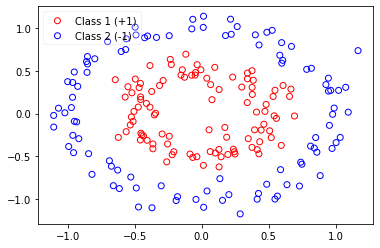

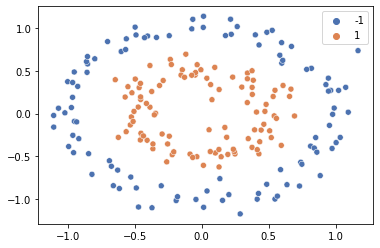

In [14]:
# matplotlib:
plt.scatter(class1_x[:, 0], class1_x[:, 1],
            label = "Class 1 (+1)",
            color = "none",
            edgecolor = "red"
           )
plt.scatter(class2_x[:, 0], class2_x[:, 1],
            label = "Class 2 (-1)",
            color = "none",
            edgecolor = "blue"
           )
plt.legend(loc="upper left", framealpha=0.25)
plt.show()
# simpler with seaborn:
plot_raw = sns.scatterplot(x=x_vals[:,0], y=x_vals[:, 1],
                           hue=t_vals, palette="deep")

## Task:
### (a)
*Implement:*
* *a linear kernel:* $K(\mathbf{x}_1, \mathbf{x}_2) = \mathbf{x}_1^\intercal \mathbf{x}_2$
* *a Gaussian or radial basis function (RBF) kernel:* $K(\mathbf{x}_1, \mathbf{x}_2) = e^{(-\gamma \|\mathbf{x}_1 - \mathbf{x}_2 \|^2)}$
* *a polynomial kernel:* $K(\mathbf{x}_1, \mathbf{x}_2) = (\mathbf{x}_1^\intercal \mathbf{x}_2 + c)^d$

#### Here can can write your solution:

In [23]:
#type='linear'
#type='gaussian'
type='polynomial'

def my_kernel(x, t):
    #x is matrix over all dimensions x1, x2, ...

    kernel = np.empty((200,200))
    if type=='linear':
        # linear kernel
        for i, x in enumerate(x):
            for j, y in enumerate(t):
                kernel[i,j] = x.T@y
        #kernel = np.dot(x, t.T)

    elif type=='gaussian':
        # Gaussian (RBF) kernel
        gamma = -3 #1/2*sigma^2
        xt = x-t
        #kernel = np.exp(-gamma * xt.dot(xt.T))
        for i,x in enumerate(x):
            for j,y in enumerate(t):
                kernel[i,j] = np.exp(-gamma * (x-y)**2)

    elif type=='polynomial':
        # polynomial kernel
        #c = -4
        #d = 5
        c = 0
        d = 50
        for i,x in enumerate(x):
            for j,y in enumerate(t):
                kernel[i,j] = (x.T@y + c)**d
        #kernel = (x.dot(t.T) + c)**d

    return kernel

#### Perform optimisation of the SVM via a manual iteration

https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC.decision_function
We start the training loop for the SVM.  We will randomly choose a batch of points and run the train step.  Then we calculate the loss and accuracy.

In [24]:
# set up the SVM model
# we use max_iter=1 so that we can iterate manually below
clf = svm.SVC(kernel=my_kernel, max_iter=1, tol=0.001)
batch_size = N  # we start with a batch size equal of the dataset size, but we can try out smaller ones!
epochs = 10000

# training loop
temp_losses = []
batch_accs = []
np.random.seed(0) # set this for your experiments to compare the different kernels
for i in range(epochs):
    # generate random indices equal to batch_size
    batch_idxs = np.random.choice(N, size=batch_size)
    # get the corresponding input and target points
    batch_x = x_vals[batch_idxs]
    batch_t = t_vals[batch_idxs][:,]
    #print(np.shape(batch_x), np.shape(batch_t))

    # train the model with this batch
    clf.fit(batch_x, batch_t)

    # calculate temporary train accuracy
    accuracy = clf.score(batch_x, batch_t)
    batch_accs.append(accuracy)

    if (i+1)%1000==0:
        print("Step #{}".format(i+1))
        print("Accuracy = ", accuracy)

Step #1000
Accuracy =  0.465
Step #2000
Accuracy =  0.54
Step #3000
Accuracy =  0.475
Step #4000
Accuracy =  0.755
Step #5000
Accuracy =  0.495
Step #6000
Accuracy =  0.685
Step #7000
Accuracy =  0.495
Step #8000
Accuracy =  0.61
Step #9000
Accuracy =  0.585
Step #10000
Accuracy =  0.735


*To plot a pretty picture of the regions we fit, we create a fine mesh to run through our model and get the predictions.*

In [25]:
# find boundaries for contour plot
abscissa_min, abscissa_max = x_vals[:, 0].min()-1, x_vals[:, 0].max()+1
ordinate_min, ordinate_max = x_vals[:, 1].min()-1, x_vals[:, 1].max()+1

# generate mesh grid of points
#h = .025  # step size in the mesh
#xx, yy = np.meshgrid(np.arange(abscissa_min, abscissa_max, h), np.arange(ordinate_min, ordinate_max, h))
xx, yy = np.meshgrid(
    np.linspace(abscissa_min, abscissa_max, 10),
    np.linspace(ordinate_min, ordinate_max, 20)
)

grid_points = np.c_[xx.ravel(), yy.ravel()]
print(np.shape(grid_points))

print(xx)
print(yy)
grid_preds = clf.predict(grid_points)  # this is not a clean way to do and will raise a warning (we only process values here, but trained with dataframes that had names), but for our purpose that's fine
grid_preds = grid_preds.reshape(xx.shape)


(200, 2)
[[-2.10384012 -1.62938046 -1.15492081 -0.68046115 -0.2060015   0.26845815
   0.74291781  1.21737746  1.69183712  2.16629677]
 [-2.10384012 -1.62938046 -1.15492081 -0.68046115 -0.2060015   0.26845815
   0.74291781  1.21737746  1.69183712  2.16629677]
 [-2.10384012 -1.62938046 -1.15492081 -0.68046115 -0.2060015   0.26845815
   0.74291781  1.21737746  1.69183712  2.16629677]
 [-2.10384012 -1.62938046 -1.15492081 -0.68046115 -0.2060015   0.26845815
   0.74291781  1.21737746  1.69183712  2.16629677]
 [-2.10384012 -1.62938046 -1.15492081 -0.68046115 -0.2060015   0.26845815
   0.74291781  1.21737746  1.69183712  2.16629677]
 [-2.10384012 -1.62938046 -1.15492081 -0.68046115 -0.2060015   0.26845815
   0.74291781  1.21737746  1.69183712  2.16629677]
 [-2.10384012 -1.62938046 -1.15492081 -0.68046115 -0.2060015   0.26845815
   0.74291781  1.21737746  1.69183712  2.16629677]
 [-2.10384012 -1.62938046 -1.15492081 -0.68046115 -0.2060015   0.26845815
   0.74291781  1.21737746  1.69183712  2.1

*Then we make the plot of our points and our decision boundary.*

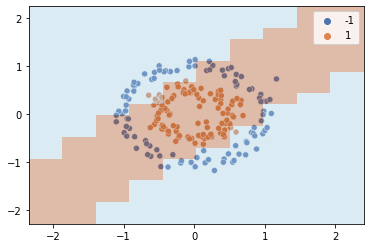

In [26]:
plot_rsk = sns.scatterplot(x=x_vals[:,0], y=x_vals[:,1],
                           hue=t_vals, cmap=plt.cm.Paired, palette="deep")
plot_rsk.pcolormesh(xx, yy, grid_preds, cmap=plt.cm.Paired, alpha=0.4)

We can also plot the accuracy over the training batches:

<AxesSubplot:xlabel='Batch', ylabel='Accuracy'>

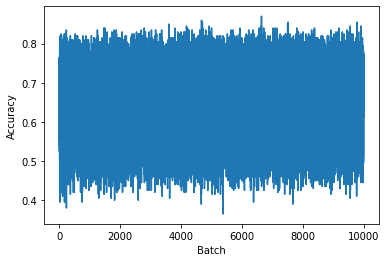

In [27]:
batch_accs_pd = pd.DataFrame({'Batch': [k for k in range(len(batch_accs))], 'Accuracy': batch_accs})
sns.lineplot(data=batch_accs_pd, x="Batch", y="Accuracy")

## Task:
### (b)
*Which of these performs best on the data, in terms of speed and quality? Do not forget to set the random seed to receive reproducible results.*

Linear:
Accuracy : 0.46 accuracy, speed: 4.3 sec

Guassian : 0.43-0.59 accuracy, speed: 7.9 sec

Polynomial : 0.4-0.8 accuracy, speed 5 sec.

### (c)
*Test different values of $c$ and $d$ for the polynomial kernel. Which of them work best?*

C should be around 0, as this will center the area. d should be 2 or 4 to get most of the inner but not all of the outer circle

### (d)
*Test different values of $\gamma$ for the RBF kernel. Which of them works best?*

I didn't find gamma to do much difference, probably because of a bug prior to this

### (e)
*Change the part of the code which generates the data such that it becomes linearly separable.*

In [20]:
datasets.make_biclusters(shape=[2,1], n_clusters=2, noise=noise)

(array([[49.00784965],
        [48.91335104]]),
 array([[False, False],
        [ True,  True]]),
 array([[False],
        [ True]]))

### (f)
*Re-evaluate the three kernels. Do you get the same result?*

I asumme that linear will perform a lot better than before and maybe even best for not overfitting